# WTI and DXY correlation 
- verify the assumption that since WTI - like Brent - are denominated in US dollars globally, 
a stronger dollar pressures crude priecs

TODO :
- [x] Get WTI data
- [ ] Get DX-Y data
- [ ] Join on date
- [ ] Compute correlation


In [ ]:
import polars as pl
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import datetime as dt

raw_data_folder = Path("../raw_data")
commo_folder = raw_data_folder / "commo"
commo_folder = commo_folder.resolve()
print(f"Raw data location : {commo_folder}\n")
print("Current data files :")
for p in list(commo_folder.glob("*")):
    print(f"\t- {p}")

Raw data location : /home/leonc/code/irbackend/raw_data/commo

Current data files :
	- /home/leonc/code/irbackend/raw_data/commo/Cushing_OK_WTI_Spot_Price_FOB.csv


## Load data

### WTI

In [15]:
with open(commo_folder / "Cushing_OK_WTI_Spot_Price_FOB.csv") as f:
    for i in range(10):
        print(f.readline())

Cushing OK WTI Spot Price FOB

https://www.eia.gov/dnav/pet/hist/RWTCD.htm

09:19:15 GMT+0100 (British Summer Time)

Data Source: Thomson Reuters

Day,Cushing OK WTI Spot Price FOB  Dollars per Barrel

07/14/2025,68.19

07/11/2025,69.63

07/10/2025,67.78

07/9/2025,69.61

07/8/2025,69.55



In [56]:
wti = (
    pl.scan_csv(commo_folder / "Cushing_OK_WTI_Spot_Price_FOB.csv", skip_rows=4)
    .with_columns(pl.col("Day").str.to_date("%m/%d/%Y"))
    .rename(
        {
            "Cushing OK WTI Spot Price FOB  Dollars per Barrel": "WTI spot",
            "Day": "date"
        }
    )
)
wti.head().collect()

date,WTI spot
date,f64
2025-07-14,68.19
2025-07-11,69.63
2025-07-10,67.78
2025-07-09,69.61
2025-07-08,69.55


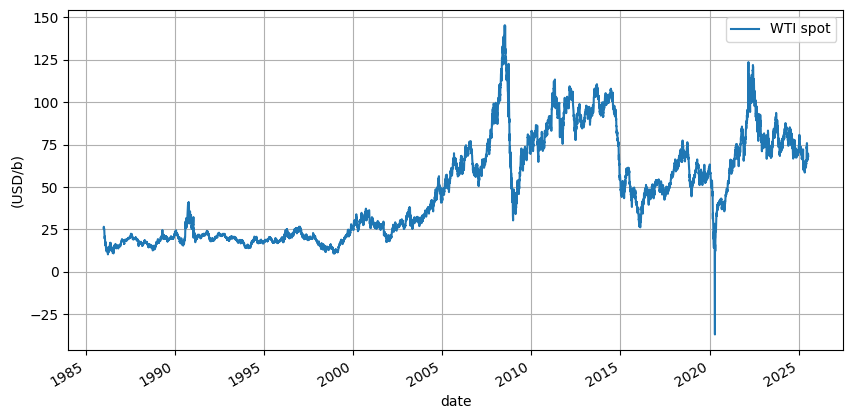

In [58]:
_ = (
    wti.collect()
    .to_pandas()
    .set_index("date")
    .plot(figsize=(10, 5), grid=True, ylabel="(USD/b)")
)

### DX-Y

In [60]:
dxy_ticker = "DX-Y.NYB"
alternative_ticker = "USDX"
# Yahoo finance decomissioned
# history not available in alphavantage
ALPHAVANTAGE_API_KEY = "FTGVVCR5TZVEY9ZH"

In [ ]:
import requests
import json

for ticker in [dxy_ticker, alternative_ticker]:
    search_url = f'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={ticker}&apikey={ALPHAVANTAGE_API_KEY}'
    search_result = requests.get(search_url).json()
    print(json.dumps(search_result, indent=2) + "\n")


quote_url = f'https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol={alternative_ticker}&apikey={ALPHAVANTAGE_API_KEY}&date=2023-06-25'
r = requests.get(quote_url)
data = r.json()

print(json.dumps(data, indent=2))


{
  "bestMatches": []
}

{
  "bestMatches": [
    {
      "1. symbol": "USDX",
      "2. name": "SGI ENHANCED CORE ETF ",
      "3. type": "ETF",
      "4. region": "United States",
      "5. marketOpen": "09:30",
      "6. marketClose": "16:00",
      "7. timezone": "UTC-04",
      "8. currency": "USD",
      "9. matchScore": "1.0000"
    }
  ]
}

{
  "endpoint": "Historical Options",
  "message": "No data for symbol USDX on date 2023-06-25. Please specify a valid combination of symbol and trading day.",
  "data": []
}


In [64]:
import pandas_datareader as pdr

def get_usd_index_fred():
    """
    Get trade-weighted USD index from FRED
    Completely free, no API key needed
    """
    try:
        # Trade Weighted U.S. Dollar Index: Broad, Goods and Services
        df = pdr.get_data_fred('DTWEXBGS', start='1985-01-01')
        df.columns = ['USD_Index']
        return df
    except Exception as e:
        print(f"FRED error: {e}")
        return None

df = get_usd_index_fred()
df.head()

,USD_Index
DATE,
2006-01-02,101.4155
2006-01-03,100.7558
2006-01-04,100.2288
2006-01-05,100.2992
2006-01-06,100.0241


<Axes: xlabel='DATE'>

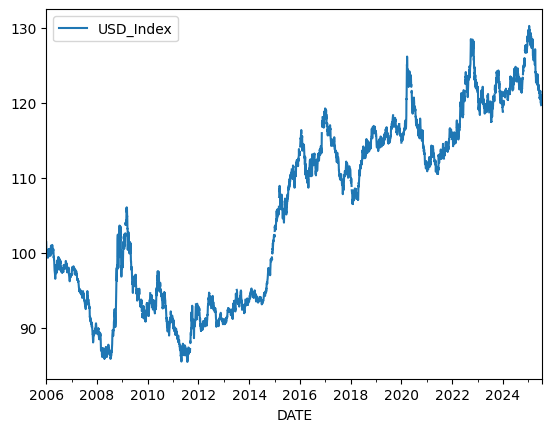

In [52]:
df.plot()

In [55]:
df.index[0], wti.collect().to_pandas().set_index("Day").index[0]

(Timestamp('2006-01-02 00:00:00'), Timestamp('2025-07-14 00:00:00'))

In [ ]:
# check that the API service is available (running in podman localhost)
ipx = {
    "API": {
        "dev": "http://127.0.0.1:8000/"
        "staging": ""
    }
}

# query max dollar index history



***
## Sources

- https://open.spotify.com/episode/0LroaxByEYdHk5Bbzg7CMM

Data :
- https://finance.yahoo.com/quote/DX-Y.NYB/history/
- https://www.eia.gov/dnav/pet/hist/RWTCD.htm
